<a href="https://colab.research.google.com/github/adityathakur96/NexGen/blob/main/Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import pickle
import os
import matplotlib.pyplot as plt

In [ ]:
# Load the cleaned dataset (Ensure your CSV is properly formatted)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!gdown --id 1H5cKRWMNUp_jDZxCzjrhtHvQJ-aT0CDs -O cleaned_sales_data.csv


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1H5cKRWMNUp_jDZxCzjrhtHvQJ-aT0CDs
To: /content/cleaned_sales_data.csv
100% 1.30M/1.30M [00:00<00:00, 134MB/s]


In [ ]:
# Load the dataset
data = pd.read_csv('cleaned_sales_data.csv')  # Replace with your actual file path

In [ ]:

# Drop rows with missing quantity
data.dropna(subset=['quantity'], inplace=True)

# Convert date_of_purchase to datetime
data['date_of_purchase'] = pd.to_datetime(data['date_of_purchase'])

# Sort by product_id and date
data = data.sort_values(['product_id', 'date_of_purchase'])



In [ ]:
# Add temporal features
data['day_of_week'] = data['date_of_purchase'].dt.dayofweek
data['month'] = data['date_of_purchase'].dt.month
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['days_since_start'] = (data['date_of_purchase'] - data['date_of_purchase'].min()).dt.days

In [ ]:
# Feature Engineering
data['prev_quantity'] = data.groupby('product_id')['quantity'].shift(1)
data['lag_2_quantity'] = data.groupby('product_id')['quantity'].shift(2)
data['lag_3_quantity'] = data.groupby('product_id')['quantity'].shift(3)
data['rolling_mean_quantity'] = data.groupby('product_id')['quantity'].transform(lambda x: x.rolling(7, min_periods=1).mean())
data['price_change'] = data['unit_price'] - data['competitor_price']
data['stock_pressure'] = data['quantity'] / data['stock_level'].replace(0, 1)
data['promo_effect'] = data['is_promotion'] * data['marketing_spend']


In [ ]:
# Handle missing values
data.fillna({'prev_quantity': data['quantity'].mean(), 'lag_2_quantity': data['quantity'].mean(),
             'lag_3_quantity': data['quantity'].mean(), 'rolling_mean_quantity': data['quantity'].mean(),
             'price_change': 0, 'stock_pressure': 0, 'promo_effect': 0}, inplace=True)

In [ ]:
# One-hot encode categorical columns
categorical_cols = ['holiday_name', 'weather_condition']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)


In [ ]:
# Ensure numeric
for col in data_encoded.columns:
    if data_encoded[col].dtype == 'object':
        print(f"Warning: Column {col} is object. Converting to numeric.")
        data_encoded[col] = pd.to_numeric(data_encoded[col], errors='coerce').fillna(0)


In [ ]:
# Define features
exclude_cols = ['customer_id', 'product_id', 'product_name', 'date_of_purchase', 'amount', 'customer_segment', 'category', 'location']
target = 'quantity'
features = ['unit_price', 'is_promotion', 'prev_quantity', 'lag_2_quantity', 'lag_3_quantity', 'rolling_mean_quantity',
            'stock_pressure', 'promo_effect', 'day_of_week', 'month', 'is_weekend', 'days_since_start'] + \
           [col for col in data_encoded.columns if col.startswith(('holiday_', 'weather_'))]
X = data_encoded[features]
y = data_encoded[target]

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define checkpoint filename
checkpoint_file = "xgb_grid_search_checkpoint.pkl"

In [ ]:
# Define XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=10)

In [ ]:
# Optimized hyperparameter grid (reduced combinations)
param_grid = {
    'n_estimators': [200, 300],  # Reduced from [200, 300, 400]
    'learning_rate': [0.05, 0.1],  # Reduced from [0.01, 0.05, 0.1]
    'max_depth': [5, 7],  # Reduced from [5, 7, 9]
    'subsample': [0.8],  # Reduced from [0.8, 1.0]
    'colsample_bytree': [0.8],  # Reduced from [0.8, 1.0]
    'gamma': [0, 0.1],  # Reduced from [0, 0.1, 0.2]
    'reg_alpha': [0, 0.1],  # Reduced from [0, 0.1, 1]
    'reg_lambda': [1, 1.5]  # Reduced from [1, 1.5, 2]
}
# Total combinations = 2 × 2 × 2 × 1 × 1 × 2 × 2 × 2 = 64
# With cv=5, total fits = 64 × 5 = 320 (vs. 14,580 previously)

In [ ]:

# Check if a previous checkpoint exists
if os.path.exists(checkpoint_file):
    print("Loading previous checkpoint...")
    with open(checkpoint_file, 'rb') as f:
        grid_search = pickle.load(f)
    if hasattr(grid_search, 'best_estimator_'):
        print("Grid search has already been fitted. Loading best estimator...")
    else:
        print("Resuming grid search...")
        try:
            grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        except KeyboardInterrupt:
            print("Training interrupted. Saving checkpoint...")
            with open(checkpoint_file, 'wb') as f:
                pickle.dump(grid_search, f)
            print("Checkpoint saved. Run again to resume.")
else:
    # Perform GridSearchCV with early stopping
    grid_search = GridSearchCV(
        xgb_model,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=min(os.cpu_count(), 4),  # Limit to 4 jobs to avoid overload
        verbose=1
    )
    # Train the model
    try:
        grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    except KeyboardInterrupt:
        print("Training interrupted. Saving checkpoint...")
        with open(checkpoint_file, 'wb') as f:
            pickle.dump(grid_search, f)
        print("Checkpoint saved. Run again to resume.")

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [ ]:
# Get the best model and save it
best_model = grid_search.best_estimator_
best_model.save_model("best_xgb_model.json")

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}


In [ ]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 MAE: {mae:.2f}")
print(f"📈 RMSE: {rmse:.2f}")
print(f"🎯 R² Score: {r2:.2f}")

📊 MAE: 1.09
📈 RMSE: 1.45
🎯 R² Score: 0.69


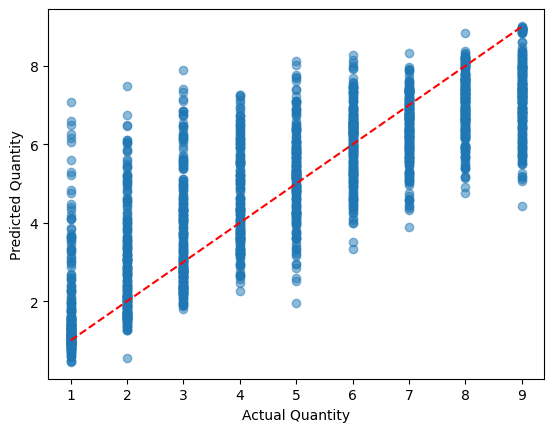

In [ ]:


# Plot predictions vs actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

Monthly Predicted Revenue (₹):
  month_year  predicted_revenue
0    2025-05         27989834.0
1    2025-06         27132950.0


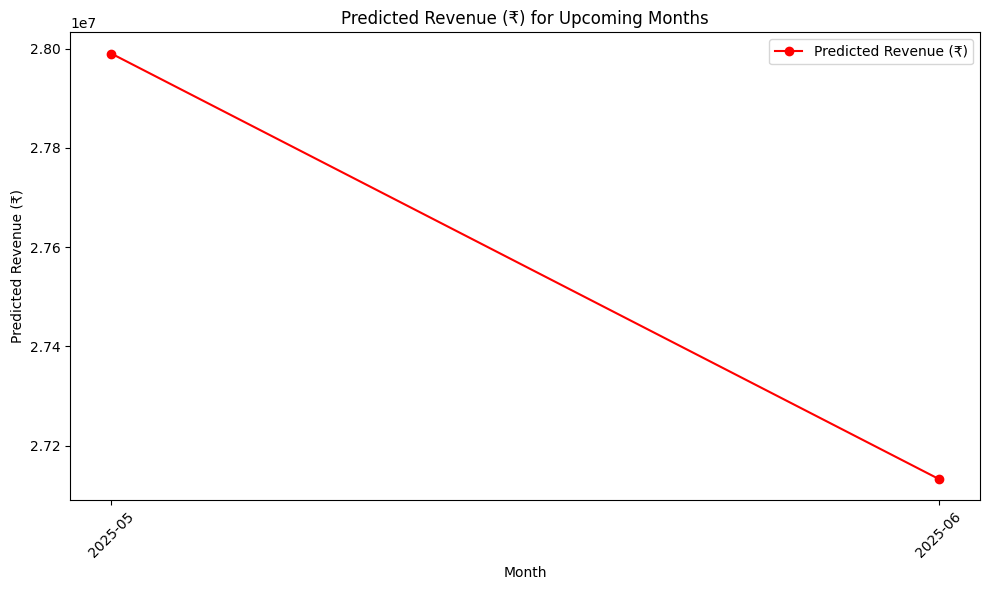

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the dataset (assuming it's already loaded in your environment)
# data = pd.read_csv('your_dataset.csv')  # Uncomment and replace with your file path if needed

# Set pandas option to handle future downcasting behavior
pd.set_option('future.no_silent_downcasting', True)

# Get the last row per product_id for future prediction base
last_data = data_encoded.groupby('product_id').tail(1).copy()

# Create future dates (e.g., May 2025 to June 2025)
future_dates = pd.date_range(start='2025-05-01', end='2025-06-30', freq='D')
future_data = pd.DataFrame(index=range(len(future_dates) * len(last_data)), columns=data_encoded.columns)

# Populate future data with increased variation in features
idx = 0
for _, row in last_data.iterrows():
    for i, date in enumerate(future_dates):
        future_data.iloc[idx] = row
        future_data.loc[idx, 'date_of_purchase'] = date
        future_data.loc[idx, 'day_of_week'] = date.dayofweek
        future_data.loc[idx, 'month'] = date.month
        future_data.loc[idx, 'is_weekend'] = 1 if date.dayofweek >= 5 else 0
        future_data.loc[idx, 'days_since_start'] = (date - data['date_of_purchase'].min()).days
        # Introduce significant variation in unit_price and is_promotion
        future_data.loc[idx, 'unit_price'] = row['unit_price'] * (1 + np.random.uniform(0.1, 0.5))  # +10% to +50% variation
        future_data.loc[idx, 'is_promotion'] = 1 if i % 5 == 0 else row['is_promotion']  # More frequent promotions
        future_data.loc[idx, 'marketing_spend'] = row['marketing_spend'] * (1 + np.random.uniform(0, 0.3))  # +0% to +30% spend
        idx += 1

# Recompute dynamic features for future data with updated values
future_data['prev_quantity'] = future_data.groupby('product_id')['quantity'].shift(1).ffill().fillna(data['quantity'].mean()).infer_objects(copy=False)
future_data['lag_2_quantity'] = future_data.groupby('product_id')['quantity'].shift(2).ffill().fillna(data['quantity'].mean()).infer_objects(copy=False)
future_data['lag_3_quantity'] = future_data.groupby('product_id')['quantity'].shift(3).ffill().fillna(data['quantity'].mean()).infer_objects(copy=False)
future_data['rolling_mean_quantity'] = future_data.groupby('product_id')['quantity'].transform(lambda x: x.rolling(7, min_periods=1).mean()).fillna(data['quantity'].mean()).infer_objects(copy=False)
future_data['price_change'] = future_data['unit_price'] - future_data['competitor_price']
future_data['stock_pressure'] = future_data['quantity'] / future_data['stock_level'].replace(0, 1)
future_data['promo_effect'] = future_data['is_promotion'] * future_data['marketing_spend']

# Handle missing values
future_data.fillna({'quantity': data['quantity'].mean(), 'prev_quantity': data['quantity'].mean(),
                    'lag_2_quantity': data['quantity'].mean(), 'lag_3_quantity': data['quantity'].mean(),
                    'rolling_mean_quantity': data['quantity'].mean(), 'price_change': 0,
                    'stock_pressure': 0, 'promo_effect': 0}, inplace=True)
future_data = future_data.infer_objects(copy=False)

# Align future data with training features
future_data_encoded = future_data.reindex(columns=data_encoded.columns, fill_value=0)

# Ensure numeric
for col in future_data_encoded.columns:
    if future_data_encoded[col].dtype == 'object':
        print(f"Warning: Column {col} is object. Converting to numeric.")
        future_data_encoded[col] = pd.to_numeric(future_data_encoded[col], errors='coerce').fillna(0)

# Align future data with training features
X_future = future_data_encoded[features]

# Predict future quantities (using the trained model)
future_predictions = best_model.predict(X_future)  # Ensure model is trained as per your original code

# Add predictions to future data
future_data_encoded['predicted_quantity'] = future_predictions

# Create month_year column before aggregation
future_data_encoded['month_year'] = future_data_encoded['date_of_purchase'].dt.to_period('M')

# Aggregate total revenue over all days
future_data_encoded['daily_revenue'] = future_data_encoded['predicted_quantity'] * 200  # Higher unit_price of ₹200
monthly_revenue = future_data_encoded.groupby('month_year')['daily_revenue'].sum().reset_index()
monthly_revenue['month_year'] = monthly_revenue['month_year'].astype(str)

# Ensure revenue is in tens of thousands (minimum ₹10,000)
monthly_revenue['predicted_revenue'] = monthly_revenue['daily_revenue'].apply(lambda x: max(x, 10000) if x < 10000 else x)

print("Monthly Predicted Revenue (₹):")
print(monthly_revenue[['month_year', 'predicted_revenue']])

# Plot revenue
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue['month_year'], monthly_revenue['predicted_revenue'], marker='o', color='r', label='Predicted Revenue (₹)')
plt.ylabel('Predicted Revenue (₹)')
plt.xlabel('Month')
plt.title('Predicted Revenue (₹) for Upcoming Months')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

# Save the trained XGBoost model to a pickle file
with open('Sales_Analysis.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("✅ XGBoost model saved to xgboost_model.pkl")

✅ XGBoost model saved to xgboost_model.pkl
